# TP 1: Resolution de Jeu de Taquin
## 1. Modélistation

On Modélise Mathématiquement notre problème par un $G=(V,E)$ avec:
- $V$ l'ensemble de configurations possibles : l'ensemble de matrices $n\times n$ qui admettent tous les éléments de $0$ à $n^2-1$
- $E$ l'ensemble de transitions: c'est l'ensemble de tous les couples de matrices $(M_1,M_2)$ où $M_1$ est $M_2$ ne sont différents que par une transition de $0$

## 2. Implémentation

### 2.1 State
Répresente un certain état du jeu, contient: 
- Matrice de dimension $n\times n$
- Position de $0$ (pour optimiser la recherche)
- Ensemble de fonctions utilitaires

In [1]:
from queue import Queue
import copy
from abc import ABC, abstractmethod
from typing import Tuple,List,Optional
import random
from __future__ import annotations
class State:
    M=int(1e9+7)
    x=random.randrange(2,M)
    def copymatrix(self,matrix:list)->list:
        '''
        Returns a clone of a matrix
        '''
        R=[]
        for row in matrix:
            R.append(row.copy())
        return R

    def __init__(self,state:List[List[int]], empty_cell:Tuple[int, int]=None):
        # If We did not provide the empty_cell (initial state), we need to search for it first
        if empty_cell is None:
            for i,row in enumerate(state):
                for j,C in enumerate(row):
                    if C==0:
                        empty_cell=(i,j)
        self.state=state
        self.empty_cell= empty_cell # The cell with value "0"
    def adjacent_states(self)->List[Tuple[State, int]]:
        '''
        Gets The list of adjacent States and their respective Id's
        ID represents the movement we did to get to this state from the previous state
        '''
        # pos=np.argmin(self.state)
        i,j = self.empty_cell
        n=len(self.state)
        adjacents=[]
        if j>0:# Left, ID:0
            S=self.copymatrix(self.state)
            S[i][j],S[i][j-1]=S[i][j-1],S[i][j]
            adjacents.append((State(S,(i,j-1)),0))
        if i>0:# Up, ID:1
            S=self.copymatrix(self.state)
            S[i][j],S[i-1][j]=S[i-1][j],S[i][j]
            adjacents.append((State(S,(i-1,j)),1))
        if i<n-1: # Down, ID:2
            S=self.copymatrix(self.state)
            S[i][j],S[i+1][j]=S[i+1][j],S[i][j]
            adjacents.append((State(S,(i+1,j)),2))
        if j<n-1: # Right, ID:3
            S=self.copymatrix(self.state)
            S[i][j],S[i][j+1]=S[i][j+1],S[i][j]
            adjacents.append((State(S,(i,j+1)),3))
        return adjacents
    def inverse_transform(self,ID:int)->State:
        '''
        Gets the Previous State Based on the Id of the current State
        '''
        i,j = self.empty_cell
        n=len(self.state)
        if ID==0: # Left, ID:0
            self.state[i][j],self.state[i][j+1]=self.state[i][j+1],self.state[i][j]
            self.empty_cell=(i,j+1)
        if ID==1: # Up, ID:1
            self.state[i][j],self.state[i+1][j]=self.state[i+1][j],self.state[i][j]
            self.empty_cell=(i+1,j)
        if ID==2: # Down, ID:2
            self.state[i][j],self.state[i-1][j]=self.state[i-1][j],self.state[i][j]
            self.empty_cell=(i-1,j)
        if ID==3: # Right, ID:3
            self.state[i][j],self.state[i][j-1]=self.state[i][j-1],self.state[i][j]
            self.empty_cell=(i,j-1)
        return self


    def __repr__(self):
        return self.state.__repr__()
    def __eq__(self, other:State)->bool:
        '''
        Overrides the Default "Equal" operation
        Checks whether this state is equal to another state (All cells are the same)
        '''
        if isinstance(other, self.__class__):
            if len(self.state)!=len(other.state):
                return False;
            n=len(self.state)
            for i in range(n):
                for j in range(n):
                    if self.state[i][j]!=other.state[i][j]:
                        return False
            return True
        else: return False

    def __ne__(self, other:State)->bool:
        '''
        Overrides the "Not Equal" Default operation
        '''
        return not(self.__eq__(other))
        
    def __lt__(self, other:State)->bool:
        '''
        Overrides the "Less Than" Default operation
        Used only by the priority queue (as a lost resort)
        '''
        return True
    def __hash__(self)->int:
        '''
        Hash function
        '''
        n=len(self.state)
        R=0
        for i,row in enumerate(self.state):
            for j,C in enumerate(row):
                R=(self.x*R+C)%self.M
        return R

### 2.2 Game
L'état global du Jeu, $\mathcal{G}=\left( v_1,v_2\right)\in V^2:$
- $v_1$ est l'état initial
- $v_2$ est l'état final

Le problème est réduit à la recherche d'un chemin de $v_1$ vers $v_2$.

#### Modélisation de chemin
Soit $\Sigma=\left\{←,↑,→,↓\right\}$ l'ensemble des labels des transitions. 
> un label est associé à la direction que $0$ a suivi durant la transition

Le chemin $\mathcal{C}\in\Sigma^*$ est la concaténation des labels de chaque transition

#### Principe
- Le parcours tient compte des états déjà visités (Graph Search)
- La liste des états visités <code>visited</code> est un map $V\rightarrow \Sigma$ qui à chaque état visité $v$ associe le label de la transition associée
- A chaque itération, on ajoute un couple $\left(v,r\right)\in V\times\Sigma$ à cette liste
- Lorsqu'une solution sera trouvée: 
    - On initialise une liste <code>path=[]</code>
    - On Construit le chemin en arrière à partir de l'état final et en ajoutant le label associé à la transition
    - Le chemin est donc la liste <code>path</code> inversée

In [2]:
from sympy.combinatorics.permutations import Permutation
class Game:
    def __get_state(self,state):
        """
        Either gets the passed state, or generates a random one if it's 'None'
        """
        if state is None:
            return self.generate_random_state()
        return state
    
    def __init__(self,first_state:list=None,final_state:list=None,n=3):
        if first_state is not None:
            self.n=len(first_state)
        else: self.n=n
        self.first_state=State(self.__get_state(first_state))
        self.final_state=State(self.__get_state(final_state))
        
    def generate_random_state(self)->List[List[int]]:
        """
        Generates a random matrix and returns it
        """
        flat_state= list(range(self.n**2))
        random.shuffle(flat_state)
        state=[]
        for i in range(self.n):
            state.append(flat_state[self.n*i:self.n*i+self.n])
        return state
    
    def __repr__(self):
        """
        Overrides the default representation for the Game object (to print it)
        """
        return '''
        This is a Taquin Game with initial State:
        {}
        And a final State 
        {}
        '''.format(self.first_state,self.final_state)

    def is_solution(self, state:State)->bool:
        """
        Checks whether a certain state is a solution ( = final state )
        """
        my_state = state.state # Gets the state grid from the state object
        for i, row in enumerate(my_state):
            for j,col in enumerate(row):
                if col != self.final_state.state[i][j]:
                    return False

        return True
    def is_solvable(self)->bool:
        """
        Checks whether this game admits a solution
        """
        P1=[]
        P2=[]
        for row in self.first_state.state:
            P1=P1+row
        for row in self.final_state.state:
            P2=P2+row
        P1.remove(0)
        P2.remove(0)
        return Permutation.parity(Permutation([i-1 for i in P1]))==Permutation.parity(Permutation([i-1 for i in P2]))

### 2.3 GameSolver:
C'est la classe qui permet de résoudre le jeu à partir d'une configuration initiale

In [3]:
class GameSolver(ABC):
    @abstractmethod
    def solve(self,game:Game):
        pass

#### 2.3.1 BfsSolver
- Utilise l'algorithme de recherche Largeur d'abord.
- **Implémentation**: File

In [4]:
class BfsSolver(GameSolver):
    """
    Solves the Game using the "Breadh First Search" Method
    Uses The "Queue" Data Structure
    """
    def solve(self,game:Game):
        visited={}
        queue=Queue()
        queue.put(game.first_state)
        visited[game.first_state]=0
        while not queue.empty():
            state = queue.get()
            if (game.is_solution(state)):
                # We build our path from the solution backwards
                path=[]
                while state!=game.first_state:
                    path.append(visited[state])
                    state.inverse_transform(visited[state])
                return (list(reversed(path)), len(visited)) 
            for (adjacent_state,ID) in state.adjacent_states():
                if adjacent_state not in visited:
                    queue.put(adjacent_state)
                    visited[adjacent_state]=ID
        return False

#### 2.3.2 DfsSolver
- Utilise l'algorithme de recherche Profondeur d'abord (Normal).
- **Implémentation**: Pile

In [5]:
class DfsSolver(GameSolver):
    """
    Solves the Game using the "Depth First Search" Method
    Uses The "Stack" Data Structure
    """
    def solve(self,game:Game):
        visited={}
        stack=list()
        stack.append(game.first_state)
        visited[game.first_state]=0
        while len(stack)>0:
            state = stack.pop()
            if (game.is_solution(state)):
                path=[]
                while state!=game.first_state:
                    path.append(visited[state])
                    state.inverse_transform(visited[state])
                return (list(reversed(path)),len(visited)) 
            for (adjacent_state,ID) in state.adjacent_states():
                if adjacent_state not in visited:
                    stack.append(adjacent_state)
                    visited[adjacent_state]=ID
        return False

#### 2.3.3 IteratedDfsSolver
- A chaque Itération, elle fait une DFS à un profondeur limitée $L$
- $L$ est augmentée avec une fonction $f\quad (L\leftarrow f(L))$
- La recherche est finie dans 2 cas
    1. Avec **succès**, Si une solution est **trouvée**
    2. Sinon avec **échec**, si toute les configurations sont **visitées** et **aucune** solution est trouvée
- **Implémentation**: Pile avec limitation de profondeur

In [6]:
class IteratedDfsSolver(GameSolver):
    """
    Solves the Game using the "Iterated Depth First Search" Method
    Uses the "Stack" Data Structure
    Limits maximum depth in each Iteration
    """
    def __init__(self,f=lambda x:x+1):
        self.f=f
    def solve(self,game:Game):
        L=0
        unvisited=set([game.first_state])
        V1=0
        V2=0
        nb_visited = 0 # number of visited cells
        while len(unvisited)>0:
            unvisited.clear()
            visited={}
            visited[game.first_state]=0
            stack=list()
            stack.append((game.first_state,0))
            visited[game.first_state]=0
            while len(stack)>0:
                state,h = stack.pop()
                unvisited.discard(state) # removes the element from the set if it exists
                if (game.is_solution(state)):
                    path=[]
                    while state!=game.first_state:
                        path.append(visited[state])
                        state.inverse_transform(visited[state])
                    return (list(reversed(path)), nb_visited+len(visited), L) 
                for (adjacent_state,ID) in state.adjacent_states():
                    unvisited.add(adjacent_state) # adjacent states are added to the unvisited list (to track what is left)
                    if not(adjacent_state in visited) and h<L:
                        stack.append((adjacent_state,h+1))
                        visited[adjacent_state]=ID
            V2=len(visited)
            nb_visited += V2
            if V1==V2: # between 2 iterations, the number of visited states stays the same => no solution
                break
            V1=V2
            L=self.f(L)
        return False

## 3. Exemples
### 3.1 Choix de Configuration

In [7]:
G=Game([[7,2,4],[5,0,6],[8,3,1]],[[0,1,2],[3,4,5],[6,7,8]])
#G=Game([[0,1],[1,2]],[[0,1],[2,3]])
#G=Game([[3,1,2],[4,5,0],[6,7,8]],[[0,1,2],[3,4,5],[6,7,8]])
print(G)


        This is a Taquin Game with initial State:
        [[7, 2, 4], [5, 0, 6], [8, 3, 1]]
        And a final State 
        [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
        


### 3.2 Choix de Solver & Résolution

In [8]:
path_encoder={0:'←',1:'↑',2:'↓',3:'→'} # à chaque ID (0,1,2,3) on associe le mouvement e ∈ Σ

In [9]:
solver1=BfsSolver() 
result = solver1.solve(G)
if result == False:
    print("Pas de solution trouvée")
else:
    p, nb_visited = result
    path=[path_encoder[s] for s in p]
    print(f"Nombre d'états visités: {nb_visited}")
    print(f"Longueur de la solution: {len(path)}")
    print("".join(path))

Nombre d'états visités: 174636
Longueur de la solution: 26
←↑→↓↓←↑→→↑←←↓→→↓←←↑→→↑←↓←↑


In [10]:
solver2=DfsSolver() 
result = solver2.solve(G)
if result == False:
    print("Pas de solution trouvée")
else:
    p, nb_visited = result
    path=[path_encoder[s] for s in p]
    print(f"Nombre d'états visités: {nb_visited}")
    print(f"Longueur de la solution: {len(path)}")
    print("".join(path))

Nombre d'états visités: 180247
Longueur de la solution: 18502
→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑↑→↓↓←↑→↓←↑→↓←←↑→→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑↑→↓↓←↑→↓←↑→↓←←↑→→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑↑→↓↓←↑→↓←↑→↑←↓→↓←↑→↓←↑↑←↓→→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑↑→↓↓←↑→↓←↑→↓←←↑→→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑↑→↓↓←↑→↓←↑→↓←←↑→→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑↑→↓↓←↑→↓←↑→↑←↓→↓←↑→↓←↑↑←↓→→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑↑→↓↓←↑→↓←↑→↓←←↑→→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑↑→↓↓←↑→↓←↑→↓←←↑→→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑↑→↓↓←↑→↓←↑→↑←↓→↓←↑→↓←↑↑←↓→→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑↑→↓↓←↑→↓←↑→↓←←↑→→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑↑→↓↓←↑→↓←↑→↓←←↑→→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑↑→↓↓←↑→↓←↑→↑←↓→↓←↑→↓←↑↑←↓→→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑→↑

In [11]:
solver3=IteratedDfsSolver(f=lambda x:2*x+1) 
result = solver3.solve(G)
if result == False:
    print("Pas de solution trouvée")
else:
    p, nb_visited, L = result
    path=[path_encoder[s] for s in p]
    print(f"Nombre d'états visités: {nb_visited}")
    print(f"Longueur de la solution: {len(path)}")
    print(f"L: {L}")
    print("".join(path))

Nombre d'états visités: 149259
Longueur de la solution: 60
L: 63
→↓←↑→↓←↑→↑←↓→↓←↑→↓←↑←↑→↓→↑←↓→↓←↑→↑←↓←↑→→↓←↓←↑↑→↓↓→↑←←↓→→↑↑←←


## 4. Analyse

### 4.1 BFS

- On remarque que le $BFS$ a bien trouvé la solution optimale ( qui est **26** Transitions )
- Ceci est dû au fait que tous les transitions ont le même coût **1**
- Il a visité **174636** pour trouver cette solution

### 4.2 DFS

- L'algorithme $DFS$ a trouvé une solution de longueur **18502** transitions et a visité **180247** états pour trouver cette solution
- Il n'a pas pû trouver la solution optimal, car cela dépend de l'ordre de développement des noeuds fils.
- pour $m=$profondeur max , et $d$=profondeur de la meilleur solution
 - on a $m>>d$ c'est pourquoi le $DFS$ a pris plus de temps pour calculer la solution que le $BFS$

### 4.3 IDFS

- L'algorithme $IDFS$ est en deuxième place, la solution trouvée a une longueur de **60** transitions
- L'algorithme $IDFS$ nous a permis de trouver la solution au moins nombre de noeuds visités que les 2 autres algorithmes, avec **149259** états visités
- La solution trouvée n'est pas optimale, ceci est dû au fait qu'on utilise la liste **closed** (*graph-search*) qui limite l'espace de recherche de l'algorithme. Aprés trouver un état dans une certaine profondeur $n_1$, on ne peut plus le traverser même si il est trouvé dans une profondeur $n_2 < n_1$.

## 5. Synthèse

- Dans la cas général: 
- pour :
  - $b$: nombre de fils maximal
  - $d$: profondeur de la meilleur solution
  - $m$: profondeur maximale 
- $BFS$ 
  - Nous permet de trouver la solution optimale ( dans le cas d'un coût uniforme ) 
  - Complexité temporelle de $O(b^d)$
  - Complexité en espace de $O(b^d)$, garde tous les noeuds en mémoire, ce qui est problématique
  - Mieux adapté lorsque la profondeur de la solution est assez petite
- $DFS$
  - N'est pas généralement optimal
  - Complexité temporelle de $O(b^m)$ 
  - Complexité en espace de $O(bm)$
  - Utilisé parfois lorsque la solution a une profondeur assez grande, généralement on utilise $IDFS$
- $IDFS$
  - Combine les avantages de $BFS$ et $DFS$
  - Mieux adapté lorsqu'on ne sait pas la profondeur de la solution 

# 6. Autres algorithmes de recherche: A*

## 6.1 Principe

- C'est un algorithme de recherche informée, c'est à dire il **estime** les meilleurs noeuds à visiter pour trouver la solution
- Le choix de noeud à développer est basé sur $f(v)=g(v)+h(v)$, $\forall v \in V$ : 
  - $g(v)$: 
    - Le coût total depuis la position initiale, on suppose que tous les transitions ont un coût de **1**
    - $g(v_{adjacent})=g(v)+1$
  - $h(v)$:
    - La fonction heuristique, donne une estimation sur le coût pour atteindre le but
    - on va implémenter deux heuristiques $h_1$ et $h_2$:
      - $h_1(v)=$ nombre de noeuds $v_{ij}$ **mal placées**
      - $h_2(v)= \sum_{i,j}d(v_{ij}) ,\forall v \in V$
        - $d(v_{ij})$ répresente la distance entre le noeud $v_{ij}$ et sa position finale
- **Implémentation**: File avec priorité 

## 6.2 Implémentation
- Pour que le coût de l'ajout soit minimal, on a utilisé une `File de priorité` ( Insertion en $O(log(n))$ )
- A chaque fois on ajoute à notre file un Tuple $(f, s, g)$:
  - `f`: Le coût approximatif de l'état ( représente notre priorité )
  - `s`: L'état en question
  - `g`: Le côut actuel de l'état ( pour calculer les coûts des adjacents )
- La position de chaque valeur $x$ de la configuration finale est stockée dans un Map : $x\rightarrow(i,j)$  
  - Le but est d'optimiser le calcul de l'heuristique qu'on répète souvent.

In [12]:
import heapq
class AStarSolver(GameSolver):
    """
    Solves the Game using the "A*" Method
    """       
    def __init__(self, heuristic_number:int):
        self.heuristics = [self.heuristic1, self.heuristic2]
        self.heuristic = self.heuristics[heuristic_number-1]
        
    def init_final_map(self, final_state):
        """
        Maps each number to its position in the matrix
        """
        map = {}
        for (i,row) in enumerate(final_state.state):
            for (j,C) in enumerate(row):
                map[C] = i,j
        return map
    
    def heuristic1(self, state:State)->int:
        """
        Our first heuristic function: number of elements in the wrong spot
        """
        final_matrix= self.game.final_state.state
        matrix = state.state
        wrong_spots = 0
        for i,row in enumerate(matrix):
            for j,C in enumerate(row):
                if C != final_matrix[i][j]:
                    wrong_spots+=1
        return wrong_spots
    
    def heuristic2(self, state:State)->int:
        """
        Our second heuristic function: Sum of distances
        """
        final_matrix= self.game.final_state.state
        matrix = state.state
        sum = 0
        for i1,row in enumerate(matrix):
            for j1,C in enumerate(row):
                i2,j2 = self.final_map[C]
                sum+= abs(i2-i1) + abs(j2-j1)
        return sum

    def f(self,state: State, cost:int)->int:
        return self.heuristic(state) + cost

    def solve(self, game: Game):
        self.game = game
        self.final_map = self.init_final_map(self.game.final_state) # initializes a map
        visited = {}
        heap =  list()
        heap.append((self.f(game.first_state,0), game.first_state, 0 ))
        heapq.heapify(heap)
        k=0
        while (len(heap)!= 0):
            f, state, cost = heapq.heappop(heap)
            if (game.is_solution(state)):
                path=[]
                while state!=game.first_state:
                    path.append(visited[state])
                    state.inverse_transform(visited[state])
                return (list(reversed(path)),len(visited)) 
            for (adjacent_state,ID) in state.adjacent_states():
                if adjacent_state not in visited:
                    heapq.heappush(heap,(self.f(adjacent_state, cost+1),adjacent_state, cost+1))
                    visited[adjacent_state]=ID
        return False

## 6.3 Exemple

On va utiliser le même exemple qu'avant

In [13]:
G=Game([[7,2,4],[5,0,6],[8,3,1]],[[0,1,2],[3,4,5],[6,7,8]])
print(G)
path_encoder={0:'←',1:'↑',2:'↓',3:'→'} # à chaque ID (0,1,2,3) on associe le mouvement e ∈ Σ


        This is a Taquin Game with initial State:
        [[7, 2, 4], [5, 0, 6], [8, 3, 1]]
        And a final State 
        [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
        


### 6.3.1 Heuristic 1

In [14]:
solver4=AStarSolver(1)
result = solver4.solve(G)

if result == False:
    print("Pas de solution trouvée")
else:
    p, nb_visited = result
    path=[path_encoder[s] for s in p]
    print(f"Nombre d'états visités: {nb_visited}")
    print(f"Longueur de la solution: {len(path)}")
    print("".join(path))

Nombre d'états visités: 56553
Longueur de la solution: 26
←↑→↓↓←↑→→↑←←↓→→↓←↑→↑←↓↓←↑↑


### 6.3.2 Heuristic 2

In [15]:
solver4=AStarSolver(2)
result = solver4.solve(G)

if result == False:
    print("Pas de solution trouvée")
else:
    p, nb_visited = result
    path=[path_encoder[s] for s in p]
    print(f"Nombre d'états visités: {nb_visited}")
    print(f"Longueur de la solution: {len(path)}")
    print("".join(path))

Nombre d'états visités: 4436
Longueur de la solution: 26
←↑→↓→↓←←↑→→↓←←↑→→↑←←↓→→↑←←


### 6.3.3 Comparaison
Dans cette partie, on a généré $1000$ configurations du jeu de taquin:
- Pour chaque configuration solvable, on a fait 2 simulations de $A^*$, chacune avec la fonction heuristique correspondante, et on a associé la longueur de la solution avec le nombre de noeuds visités pour chaque méthode (la longueur est la même pour une même simulation puisque les deux heuristiques sont admissibles)
- Formellement, la longueur de solution $X$, le nombre des noeuds visités $Y_1,Y_2$ des deux méthodes sont des variables aléatoires. On va tracer donc les courbes $y_1=\mathbb{E}[Y_{1}|X=x]$ et $y_2=\mathbb{E}[Y_{2}|X=x]$ pour faire une comparaison des deux méthodes.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

m=1000
final_state=[[3*i+j for j in range(3)] for i in range(3)]
X=[]
Y1=[]
Y2=[]
S1=AStarSolver(1)
S2=AStarSolver(2)
for i in range(m):
    G=Game(final_state=final_state,n=3)
    if not G.is_solvable():
        continue
    p2,n2=S2.solve(G)
    h=len(p2)
    p1,n1=S1.solve(G)
    X.append(h)
    Y2.append(n2)
    Y1.append(n1)

[None]

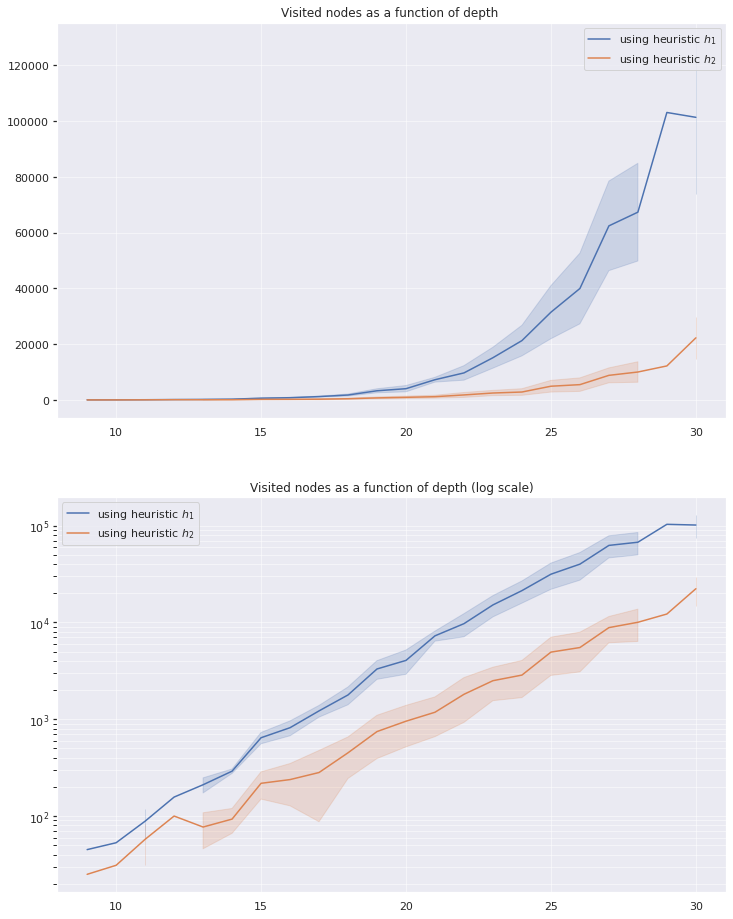

In [17]:
from matplotlib.ticker import MultipleLocator,AutoMinorLocator
sns.set_theme(style="darkgrid")
fig,axs=plt.subplots(2,1,figsize=(12,16))
for i,ax in enumerate(axs):
    sns.lineplot(x=X,y=Y1,label="using heuristic $h_1$",ci="sd",n_boot=10,ax=ax)
    sns.lineplot(x=X,y=Y2,label="using heuristic $h_2$",ax=ax,ci="sd",n_boot=10)
    ax.set_title("Visited nodes as a function of depth {}".format("" if i==0 else "(log scale)"))
    ax.grid(b=True, which='both', color="white", linewidth=0.5)
    ax.tick_params(axis='y', which='both', direction='out', length=4, left=True)
axs[1].set(yscale="log")


## 6.4 Analyse

- Les deux heuristiques ont bien permis de trouver la solution la plus courte ( de **26** transitions ), cependant ce n'est pas exactement la même solution, cette configuration a alors plusieurs solutions optimales.
- On remarque que $h_1$ prend plus de temps pour calculer la solution, et a visité **56553** états pour trouver cette solution.
- $h_2$ nous a permis de trouver la solution plus rapidement, et n'a visité que **4436** états pour trouver cette solution.
- Ceci est dû principalement au fait que $h_2$ **domine** $h_1$ , elle est donc plus proche du **coût réel optimal**.
- De plus on a bien vérifier que **statistiquement**, $h_2$ nous permet réellement de trouver la solution plus rapidement que $h_1$ en faisant une **simulation** de $1000$ jeux.

## 6.5 Synthèse

- L'algorithme $A*$ est un algorithme complet et optimal ( sous réserve des contraintes d'admissibilité de l'heuristique )
- Le Problème majeur de $A*$ est l'espace mémoire qu'il occupe ( complexité en $O(b^d)$ )
- Le choix de l'heuristique est trés important car il peut diminuer considérablement la complexité temporelle et spatialle
- Plus une heuristique est dominante par rapport à une autre, moins le temps de résolution et l'espace mémoire qu'elle va occuper
- D'autres variantes de $A*$ existent aussi pour faire face au problème de l'espace mémoire, comme le `iterative deepening A*`